In [1]:
from dotenv import load_dotenv
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from sklearn.impute import KNNImputer
import statsmodels.api as sm
import seaborn as sns

In [2]:
#cargar el archivo csv y pasarlo a un dataframe
ds = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv').iloc[:,1:] #iloc para quitar el id
ds.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


### **1. Planteamiento del problema y recopilación de datos**

In [3]:
#Observo el tipo de datos(variables) que tenemos en el dataset
ds.dtypes

name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

Podemos observar que existen tanto variables categóricas como numéricas.

In [5]:
ds.shape

(48895, 15)

Vemos que el dataset está compuesto por 48895 observaciones y 15 variables.

### **2. Exploración y limpieza de datos**

In [6]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            48879 non-null  object 
 1   host_id                         48895 non-null  int64  
 2   host_name                       48874 non-null  object 
 3   neighbourhood_group             48895 non-null  object 
 4   neighbourhood                   48895 non-null  object 
 5   latitude                        48895 non-null  float64
 6   longitude                       48895 non-null  float64
 7   room_type                       48895 non-null  object 
 8   price                           48895 non-null  int64  
 9   minimum_nights                  48895 non-null  int64  
 10  number_of_reviews               48895 non-null  int64  
 11  last_review                     38843 non-null  object 
 12  reviews_per_month               

Podemos ver que hay variables como "last_review" y " reviews_per_month" que van a contener una gran cantidad de valores nulos.

In [7]:
#Comprovar el % de valores nulos para cada variable
ds.isnull().mean()*100 

name                               0.032723
host_id                            0.000000
host_name                          0.042949
neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       20.558339
reviews_per_month                 20.558339
calculated_host_listings_count     0.000000
availability_365                   0.000000
dtype: float64

Un 20.55% de nulos para las dos variables tienen. Vemos que name y host_name también tienen algunos valores nulos.

In [8]:
#Observar si las variables toman diferentes valores
ds.nunique()

name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

Vemos que las variables almenos pueden tomar 3 valores diferentes por lo que no tenemos ninguna constante, ya que seria inneceseria incluirla en el modelo predictivo.

In [16]:
# Aquí miramos si hay valores duplicados en el dataset
ds.duplicated().sum()

np.int64(0)

In [4]:
# Comprovamos si hay duplicados pero sin tener en cuenta las columnas identificadores del anuncio
ds.drop(columns=['name', 'host_id', 'host_name']).duplicated().sum()

np.int64(0)

Por suerte no tenemos observaciones duplicadas en el dataset

In [3]:
## Eliminar información irrelevante
ds.drop(columns=['name', 'host_id', 'host_name', 'calculated_host_listings_count', 'last_review' ], inplace= True) 

Considero que estas tres columnas no ofrecen ningún tipo de valor al modelo predictivo, por eso procedo a eliminarlas

### **3. Análisis de variables univariante**

#### 3.1 Análisis sobre variables categóricas

In [76]:
types_df = pd.DataFrame(ds.dtypes, columns=['Type'])
types_df

,Type
neighbourhood_group,object
neighbourhood,object
latitude,float64
longitude,float64
room_type,object
price,int64
minimum_nights,int64
number_of_reviews,int64
reviews_per_month,float64
availability_365,int64


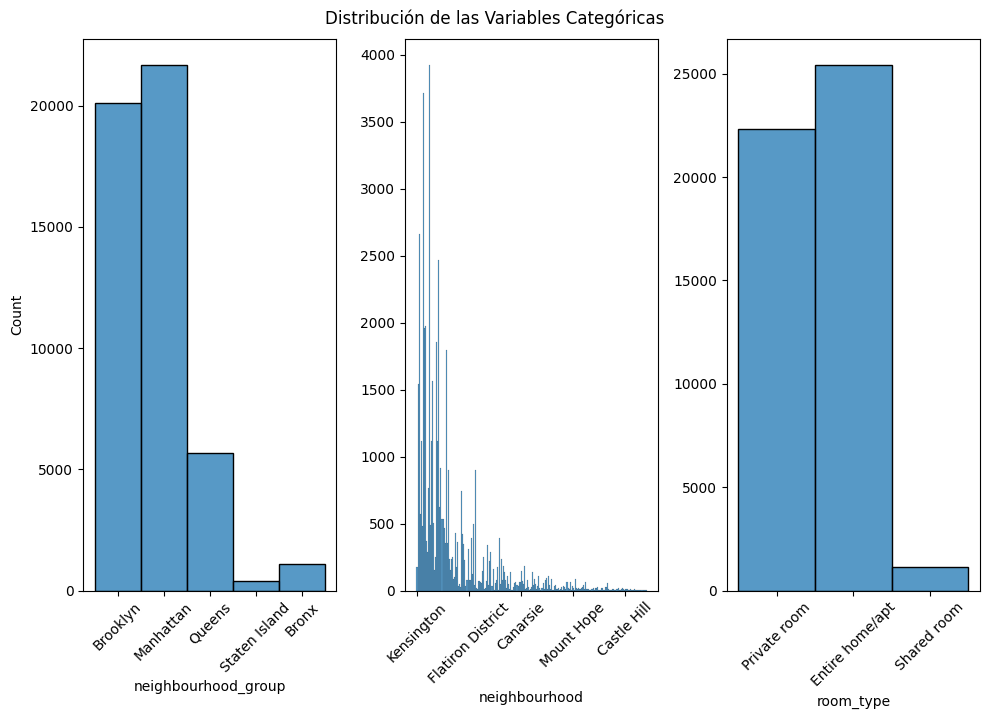

In [58]:
from matplotlib.ticker import MaxNLocator
fig, axis = plt.subplots(1,3, figsize = (10, 7))

# Crear un histograma múltiple
sns.histplot(ax = axis[0], data = ds, x = "neighbourhood_group")
axis[0].tick_params(axis='x', rotation=45)
sns.histplot(ax = axis[1], data = ds, x = "neighbourhood").set(ylabel = None)
axis[1].xaxis.set_major_locator(MaxNLocator(5))
axis[1].tick_params(axis='x', rotation=45)
sns.histplot(ax = axis[2], data = ds, x = "room_type").set(ylabel = None)
axis[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
fig.suptitle('Distribución de las Variables Categóricas', y=1.02)
plt.show()

In [53]:
#Quería observar cual es el barrio con más frecuencia
ds.value_counts('neighbourhood')

neighbourhood
Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
                      ... 
New Dorp                 1
Richmondtown             1
Rossville                1
Willowbrook              1
Woodrow                  1
Name: count, Length: 221, dtype: int64

A través de los histogramas podemos sacar las siguientes conclusiones:

1. Manhattan y Brooklyn concentran la mayor cantidad de viviendas del dataset
2. Williamsburg, Bedford-Stuyvesant y Harlem, son los vecindarios vas frecuentes en este dataset
3. El tipo de vivienda más anunciada es piso/casa completa, aunque también hay mucha cantidad de anuncios sobre habitaciones privadas

#### 3.2 Análisis sobre variables numéricas.

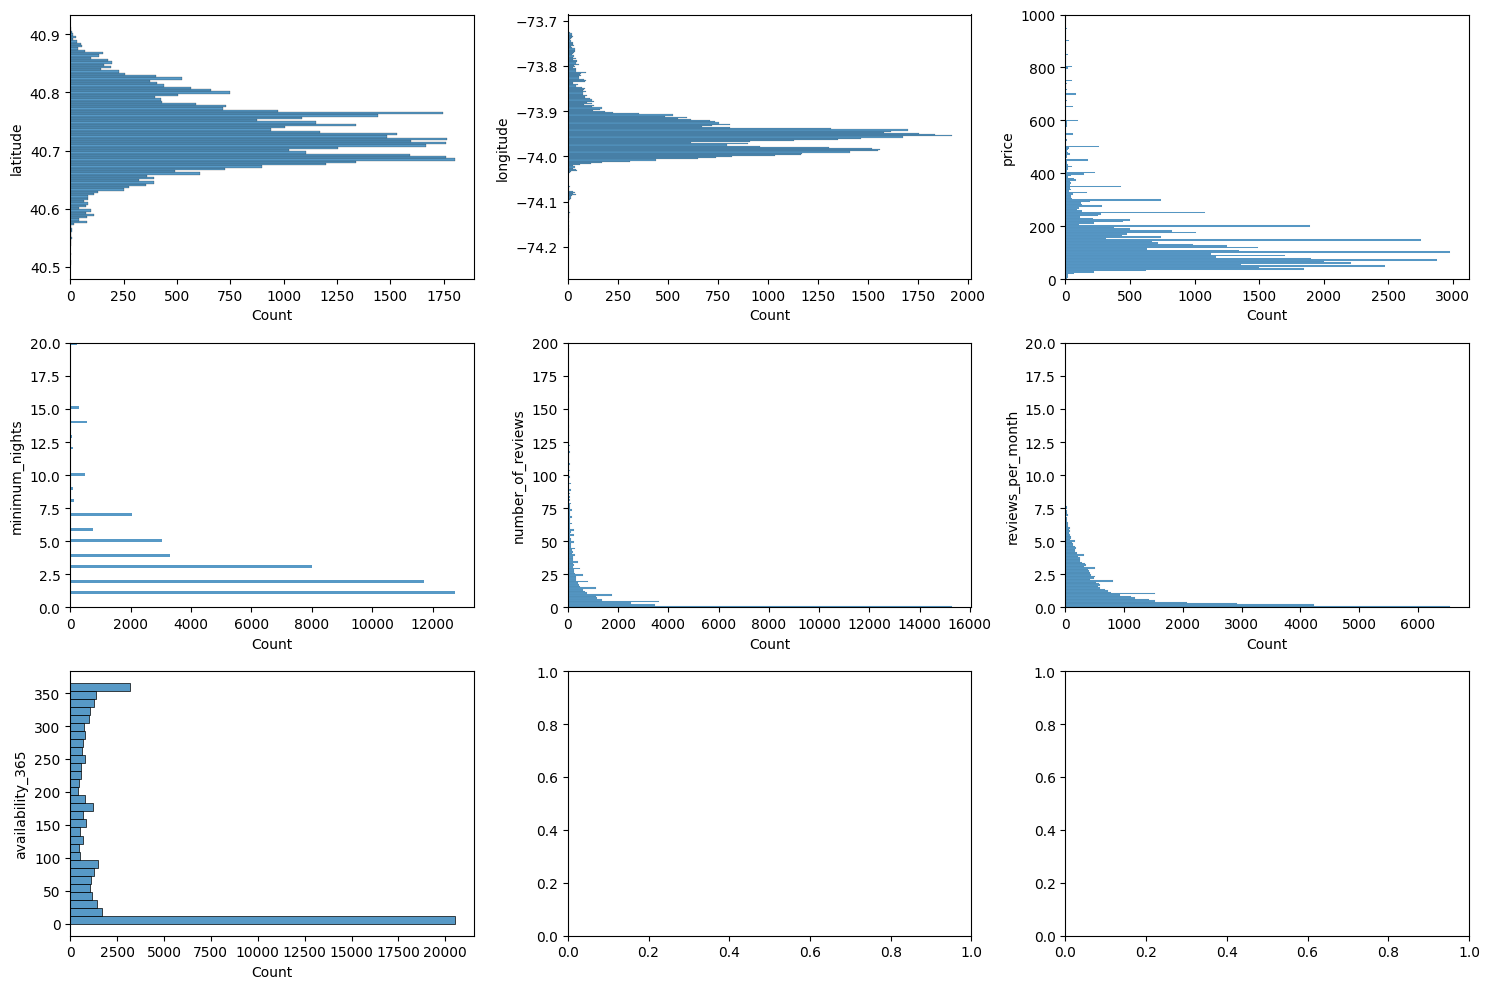

In [69]:
fig, axis = plt.subplots(3, 3, figsize = (15, 10))

sns.histplot(ax = axis[0, 0], data = ds, y = "latitude")
sns.histplot(ax = axis[0, 1], data = ds, y = "longitude")
sns.histplot(ax = axis[0, 2], data = ds, y = "price")
sns.histplot(ax = axis[1, 0], data = ds, y = "minimum_nights")
sns.histplot(ax = axis[1, 1], data = ds, y = "number_of_reviews")
sns.histplot(ax = axis[1, 2], data = ds, y = "reviews_per_month")
sns.histplot(ax = axis[2, 0], data = ds, y = "availability_365")

#Ajusto el eje_y para que se vea mejor la distrbución de las variables
axis[1,0].set_ylim(0,20)
axis[0,2].set_ylim(0,1000)
axis[1,1].set_ylim(0,200)
axis[1,2].set_ylim(0,20)
plt.tight_layout()

plt.show()

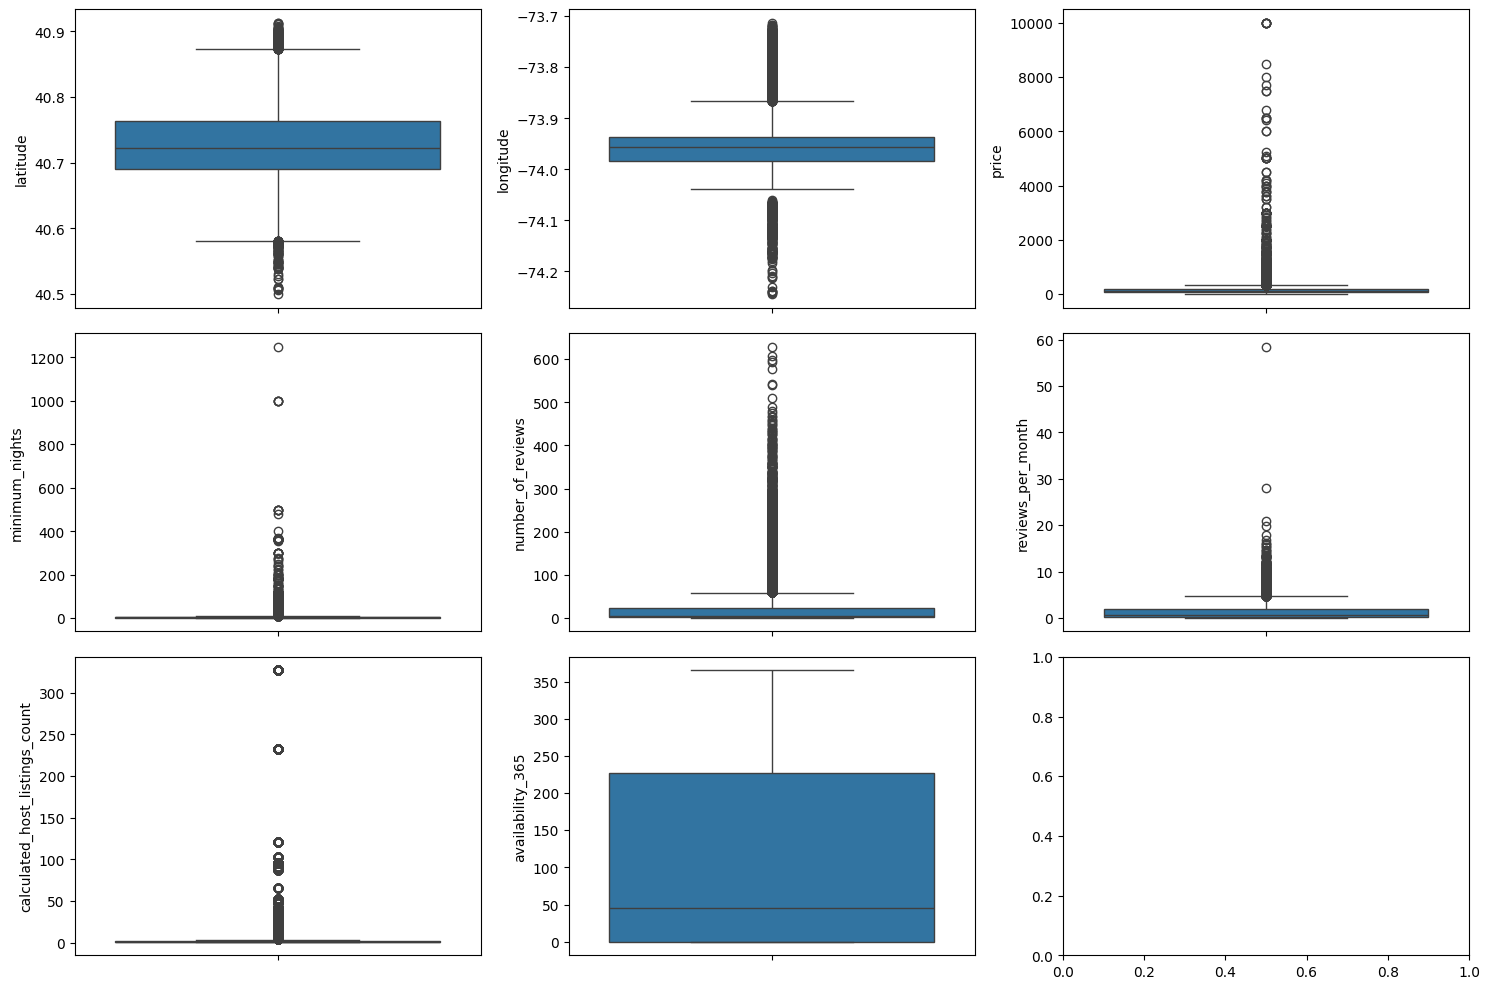

In [61]:
#Hago un conjunto de boxplots vara ver si las variables numéricas presentan muchos outliers que podrian estar afectando a las métricas de la misma variable
fig, axis = plt.subplots(3, 3, figsize = (15, 10))

sns.boxplot(ax = axis[0, 0], data = ds, y = "latitude")
sns.boxplot(ax = axis[0, 1], data = ds, y = "longitude")
sns.boxplot(ax = axis[0, 2], data = ds, y = "price")
sns.boxplot(ax = axis[1, 0], data = ds, y = "minimum_nights")
sns.boxplot(ax = axis[1, 1], data = ds, y = "number_of_reviews")
sns.boxplot(ax = axis[1, 2], data = ds, y = "reviews_per_month")
sns.boxplot(ax = axis[2, 0], data = ds, y = "calculated_host_listings_count")
sns.boxplot(ax = axis[2, 1], data = ds, y = "availability_365")

plt.tight_layout()

plt.show()

## **Ingeniería de características**

In [70]:
ds.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,48895.0,40.728949,0.054530,40.49979,40.69010,40.72307,40.763115,40.91306
longitude,48895.0,-73.952170,0.046157,-74.24442,-73.98307,-73.95568,-73.936275,-73.71299
price,48895.0,152.720687,240.154170,0.00000,69.00000,106.00000,175.000000,10000.00000
minimum_nights,48895.0,7.029962,20.510550,1.00000,1.00000,3.00000,5.000000,1250.00000
number_of_reviews,48895.0,23.274466,44.550582,0.00000,1.00000,5.00000,24.000000,629.00000
reviews_per_month,38843.0,1.373221,1.680442,0.01000,0.19000,0.72000,2.020000,58.50000
availability_365,48895.0,112.781327,131.622289,0.00000,0.00000,45.00000,227.000000,365.00000


In [72]:
#Para ver el sesgo de las distintas distribuciones de las variables
ds.skew(numeric_only= True)

latitude              0.237167
longitude             1.284210
price                19.118939
minimum_nights       21.827275
number_of_reviews     3.690635
reviews_per_month     3.130189
availability_365      0.763408
dtype: float64

Observando los histogramas y los gráficos de caja, podemos decir que, excluyendo las variables de longitud y latitud, las variables presentan una enorme cantidad de valores atípicos, por lo que más adelante vamos a tener que trabajar para poder arreglar estas variables.
Por otra parte, podemos sacar algunas conclusiones de los histogramas y de la celda de descripción general:
1. Las variables price, minimum_nights, number_of_reviews y reviews_per_month, presentan bastante sesgo hacia la izquierda (visto verticalmente). También lo podemos observar en la celda anterior donde sacamos el skewness de cada variable y vemos que sobre todo price y minimum_nights tienen un sesgo hacia la izquierda y por lo tanto su cola es más larga hacia la derecha.
2. La variable precios presenta un valor máximo demasiado alto, ya que se trata de un valor atípico y nos puede estar afectando a la media general de los precios.
3. Lo mismo pasa con la variable minimum_nights, dónde su valor máximo difiere por mucho el precentil de 75%,, el cuál es 5 noches. Seguramente se trate de la introducción errónea de una vivienda cuya estancia está más enfocada a personas que se queden más tiempo y no ha estancias más cortas, como podrian ser unas vacaciones, el cual está formado el dataset.

## Ajuste de las variables

Transformación de variables categóricas a numéricas

In [4]:
## Vamos a transformar las variables categóricas "neighborhood_group", "neighbourhood" y "room_type" en variables númericas
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Aplico el encoder a la columna
ds['neigh_group_numeric'] = label_encoder.fit_transform(ds['neighbourhood_group'])
ds['room_type_numeric'] = label_encoder.fit_transform(ds['room_type'])

# Para la variable neighbourhood voy a aplicar la técnica de Frequency Encoding porque creo que tiene más sentido en este caso
frecuencia = ds.value_counts('neighbourhood')
ds['neighbourhood_frecuency'] = ds['neighbourhood'].map(frecuencia)

#Elimino las columnas categóricas que han sido sustituidas por numéricas
ds.drop(columns= ['neighbourhood_group', 'neighbourhood', 'room_type' ], inplace= True)

ds.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,neigh_group_numeric,room_type_numeric,neighbourhood_frecuency
0,40.64749,-73.97237,149,1,9,0.21,365,1,1,175
1,40.75362,-73.98377,225,1,45,0.38,355,2,0,1545
2,40.80902,-73.94190,150,3,0,NaN,365,2,1,2658
3,40.68514,-73.95976,89,1,270,4.64,194,1,0,572
4,40.79851,-73.94399,80,10,9,0.10,0,2,0,1117


Ajuste de la variable precios

In [5]:
#Aquí voy ajustar los outliers de la variable precios
ds = ds[ds['price'] > 0] #Filtro el dataset con los precios mayores que 0
ds['Log_price'] = np.log(ds['price']) # Creo una nueva variable llamada Log_price que contiene todos los valores de los precios pasados a logaritmo

#Compruevo que efectivamente el dataset haya filtrado las filas con precio mayor que 0
print(ds.loc[ds['price'] > 0].shape)
print(ds.shape)

(48884, 11)
(48884, 11)


In [6]:
#Elimino la variable precios
ds.drop('price', axis= 1, inplace= True)

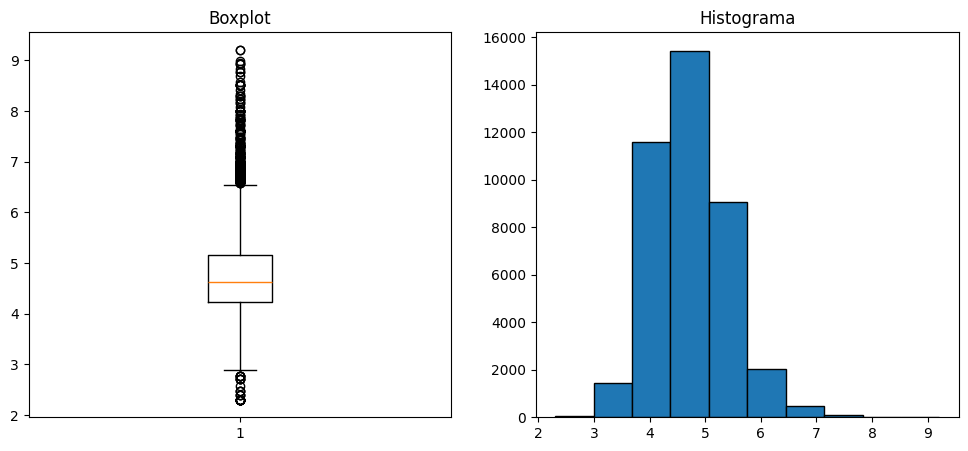

In [32]:
#Compruevo si los outliers de la variable precio han sido corregidos
fig, axis = plt.subplots(1,2, figsize = (12,5))

axis[0].boxplot(ds['Log_price'])
axis[0].set_title('Boxplot')

axis[1].hist(ds['Log_price'], edgecolor = 'black')
axis[1].set_title('Histograma')

plt.show()

Aunque sigan apareciendo outliers hemos podido corregir esa dispersión que existia en la variable original de precios

Ajuste variable minimum_nights

In [7]:
#Con la variable "minimum_nights" utilizaremos la técnica de los IQR
nights_stats = ds["minimum_nights"].describe() 

nights_iqr = nights_stats["75%"] - nights_stats["25%"]
upper_limit = nights_stats["75%"] + 1.5 * nights_iqr
lower_limit = nights_stats["25%"] - 1.5 * nights_iqr

#filtro los outliers
ds = ds.loc[ds['minimum_nights'] < upper_limit]

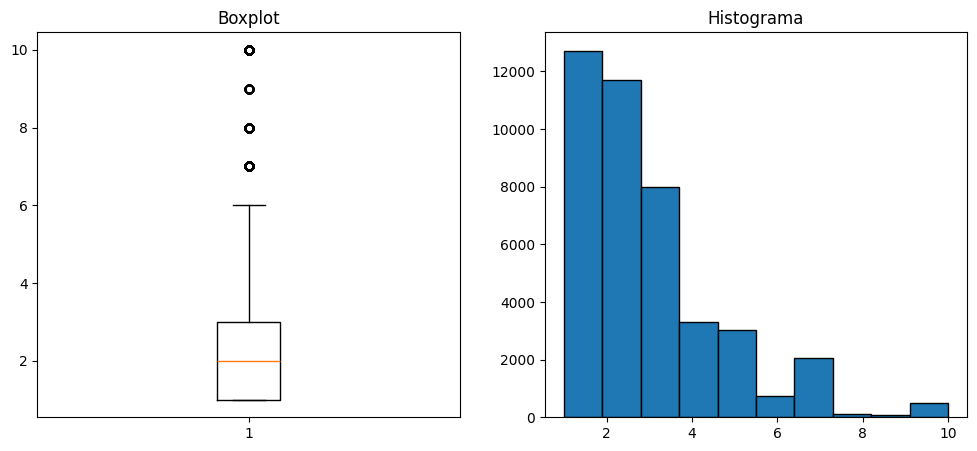

In [8]:
#Compruevo si los outliers de la variable precio han sido corregidos
fig, axis = plt.subplots(1,2, figsize = (12,5))

axis[0].boxplot(ds['minimum_nights'])
axis[0].set_title('Boxplot')

axis[1].hist(ds['minimum_nights'], edgecolor = 'black')
axis[1].set_title('Histograma')

plt.show()

En este caso hemos eliminado casi todos los outliers. Ahora ya tenemos limpias, las dos variables que más sesgo tenian del dataset

Ahora toca rellenar los valores nulos de la variable reviews_per_month. Pero antes vamos a crear una nueva variable, que se va encargar de tener en cuenta estos valores nulos en el modelo predictivo. Esta nueva variable va consistir en una variable binaria, que va tomar valor 1 cuando la observación en la variable reviews_per_month es nula (indicando que el anuncio es nuevo) y 0 cuando tenga x valor (indicando que no es nuevo)

In [9]:
#Creo una nueva columna binaria para decir si el anuncio es nuevo
ds['es_nuevo'] = ds.apply(lambda row: 1 if pd.isnull(row['reviews_per_month']) else 0, axis=1)

Una vez tengo la nueva variable creada, relleno los valores nulos de la variable reviews_per_month

In [10]:
#Relleno los valores nulos de la columna "reviews_per_month" basándome en la media de los valores de los vecinos más cercanos.
imputador_knn = KNNImputer(n_neighbors=3)
ds[['reviews_per_month']] = imputador_knn.fit_transform(ds[['reviews_per_month']])

In [120]:
#Compruevo si existen valores nulos
ds.isnull().any()

latitude                   False
longitude                  False
minimum_nights             False
number_of_reviews          False
reviews_per_month          False
availability_365           False
neigh_group_numeric        False
room_type_numeric          False
neighbourhood_frecuency    False
Log_price                  False
es_nueva                   False
es_nuevo                   False
dtype: bool

Efectivamente ya no hay valores nulos en mis observaciones

#### 3.3 Análisis de variables multivariante

3.3.1 Análisis numérico-numérico

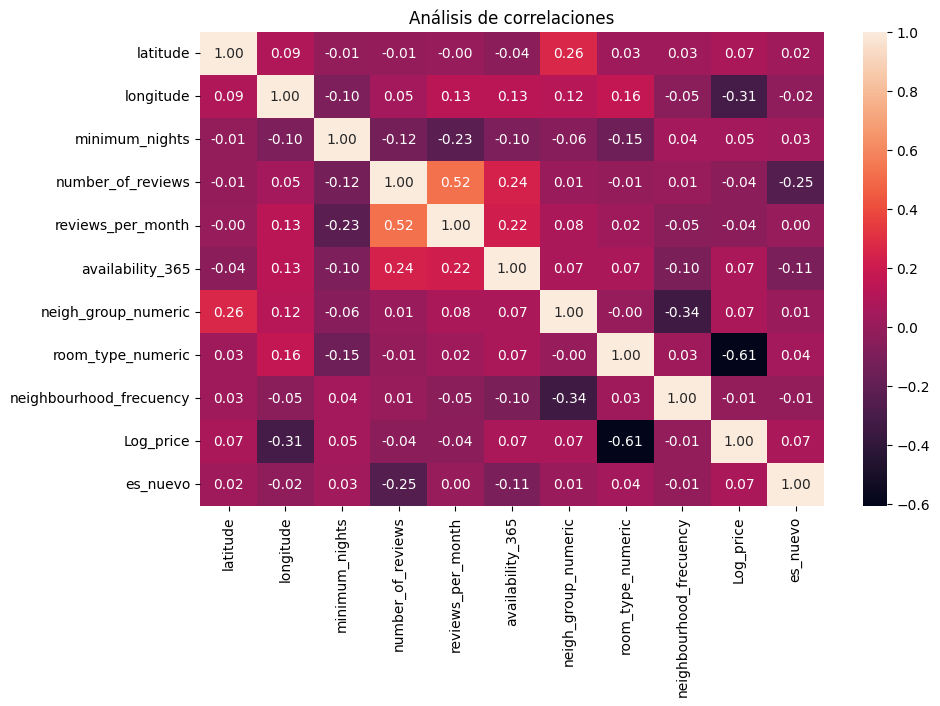

In [14]:
# Vamos analizar la correlación entre las variables numéricas para ver si hay riesgo de colinealidad
fig, axis = plt.subplots(figsize = (10, 7))

sns.heatmap(ds.corr(), annot = True, fmt = ".2f")

plt.tight_layout()
plt.title('Análisis de correlaciones')

plt.show()

Podemos observar que las variables "number_of_reviews" y "reviews_per_month" presentan una significativa correlación, por lo que vamos a fusionarlas para evitar problemas de colinealidad

### Inferencia de nuevas características

In [11]:
# Creo una nueva columna la cuál consiste en el número de meses en que los anuncios estan publicados
ds['months_active'] = ds['number_of_reviews'] / ds['reviews_per_month']

#Elimino ambas columnas
ds.drop(columns=['number_of_reviews', 'reviews_per_month'], inplace= True)

## **Iniciamos el modelo**

In [12]:
X = ds.drop(['Log_price'], axis=1)
y = ds.Log_price

# Ajusta el modelo
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Instancia de la influencia y obtención de la distancia de cook para cada observación
cooks_distance = model.get_influence().cooks_distance
cooks_distance

(array([2.67557943e-05, 3.80936693e-07, 3.26655806e-06, ...,
        5.32119312e-05, 6.80628707e-07, 1.39589465e-06]),
 array([1., 1., 1., ..., 1., 1., 1.]))

Ahora vamos a ver las observaciones que tienen más influencia de la necesaria en el modelo y que pueden afectar al algoritmo cuando quiera predecir el precio

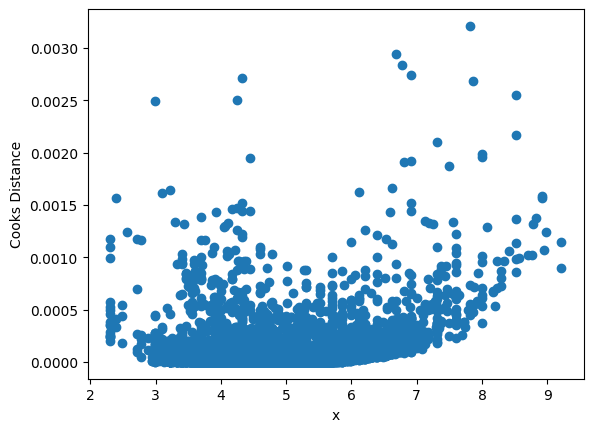

In [13]:
plt.scatter(ds.Log_price, cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

In [14]:
#Establezco el punto de corte para eliminar aquellas observaciones que superan este grado de influencia en el dataset
pto_corte = 4/len(X)
print(round(pto_corte,5))

9e-05


In [15]:
#Para observar el % de mis observaciones que superan el punto de corte y por lo tanto van a ser eliminadas
len(np.where(cooks_distance[0]>pto_corte)[0])/len(X)*100

5.633669459830516

In [16]:
# Verifica los índices que estás intentando eliminar
indices_a_eliminar = np.where(cooks_distance[0] > pto_corte)[0]  #array([   16,    23,    24, ..., 38711, 38725, 38726])
indices_existentes = ds.index.intersection(indices_a_eliminar)

print(f"Índices a eliminar que no existen en ds: {set(indices_a_eliminar) - set(indices_existentes)}") #devuelve los elementos que están en indices_a_eliminar pero no en indices_existentes


Índices a eliminar que no existen en ds: {np.int64(40968), np.int64(24592), np.int64(8213), np.int64(18460), np.int64(2078), np.int64(22564), np.int64(14379), np.int64(16432), np.int64(12342), np.int64(2112), np.int64(20546), np.int64(26711), np.int64(18526), np.int64(18534), np.int64(30823), np.int64(34920), np.int64(2153), np.int64(8301), np.int64(16498), np.int64(39027), np.int64(26759), np.int64(12425), np.int64(32915), np.int64(16532), np.int64(39069), np.int64(39076), np.int64(30894), np.int64(41141), np.int64(18620), np.int64(28871), np.int64(204), np.int64(41165), np.int64(30925), np.int64(35028), np.int64(24798), np.int64(2280), np.int64(6383), np.int64(12528), np.int64(16633), np.int64(22790), np.int64(35094), np.int64(283), np.int64(24876), np.int64(12595), np.int64(37173), np.int64(28990), np.int64(35139), np.int64(10565), np.int64(18778), np.int64(14682), np.int64(349), np.int64(29044), np.int64(14716), np.int64(14722), np.int64(387), np.int64(6542), np.int64(31123), np.in

In [26]:
len(indices_a_eliminar)

2380

In [17]:
indices_a_eliminar_validos = ds.index.intersection(indices_a_eliminar) #Obtengo los índices que deseo eliminar (indices_a_eliminar) pero que realmente existen en el dataset.
ds.drop(indices_a_eliminar_validos, inplace=True)

Ya hemos eliminado esas observaciones que podían estar afectando al modelo predictivo.

In [18]:
X = ds.drop(['Log_price'], axis=1) #para quitar la constante
y = ds.Log_price

In [19]:
# Defino las variables de entrenamiento y de test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [20]:
# Usamos xgb para conocer la importancia de las características
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train, y_train)
df_imp = pd.DataFrame({'Feature':X_train.columns, 'Importance':xgb_model.feature_importances_*100}) #Aquí se crea el nuevo df con dos columnas, una con las variables y otra con su R**2 sobre el modelo
df_imp = df_imp.sort_values(by='Importance', ascending=False) #ordeno de más importancia a menos
df_imp

,Feature,Importance
5,room_type_numeric,80.799667
1,longitude,4.121467
7,es_nuevo,3.315853
0,latitude,2.743644
3,availability_365,2.576359
4,neigh_group_numeric,1.930411
6,neighbourhood_frecuency,1.843231
8,months_active,1.384131
2,minimum_nights,1.285240


En este caso todas las variables presentan un Rsquare más grande que 1%, por lo tanto no vamos a proceder a eliminar ninguna variable del modelo.
Sin embargo, antes de continuar vamos a comprobar que no exista una gran coliniealidad entre las variables, para esto vamos a mirar el VIF de cada una de las variables del modelo

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.Series([variance_inflation_factor(X_train.corr().values, i) for i in range(X_train.corr().shape[1])], index=X_train.columns)
vif

latitude                   1.474526
longitude                  1.324716
minimum_nights             1.192744
availability_365           1.225916
neigh_group_numeric        2.286514
room_type_numeric          1.246446
neighbourhood_frecuency    1.760645
es_nuevo                   2.537394
months_active              2.570027
dtype: float64

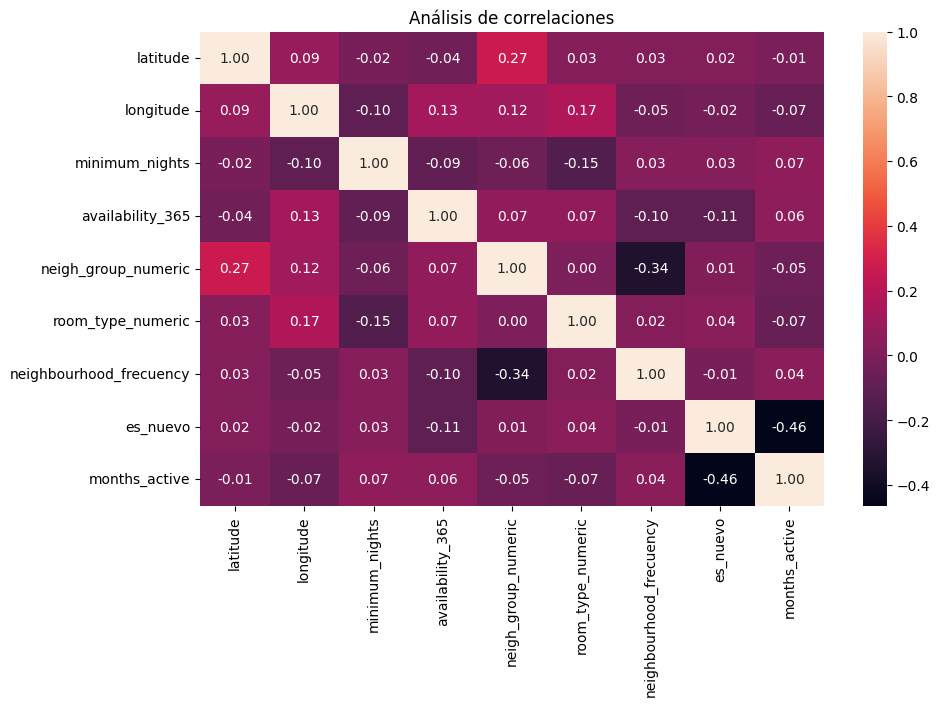

In [36]:
#Comprovamos igualmente las correlaciones
fig, axis = plt.subplots(figsize = (10, 7))

sns.heatmap(X_train.corr(), annot = True, fmt = ".2f")

plt.tight_layout()
plt.title('Análisis de correlaciones')

plt.show()

En este caso, vemos que las variables presentan un VIF por debajo de 10, por lo tanto podemos afirmar que no existe riesgo de multicolinealidad entre las variables y las correlaciones se matienen bajas. 

Ahora vamos a volver a estudiar el sesgo de las variables numéricas

In [21]:
#Antes quitamos la columna binaria "es_nuevo"
binary_cols = X_train[(X_train==0)|(X_train==1)].dropna(axis=1).columns.values
binary_cols

array(['es_nuevo'], dtype=object)

In [22]:
X_train.drop(binary_cols, axis=1).skew()

latitude                   0.267331
longitude                  1.257579
minimum_nights             1.498847
availability_365           0.944839
neigh_group_numeric        0.408043
room_type_numeric          0.345889
neighbourhood_frecuency    0.649638
months_active              1.105022
dtype: float64

Cómo podemos ver todas las variables tienen un skew (o sesgo) bajo, por lo que no existe riesgo de precisión en el modelo.

## **Escalado de valores**

### Escalado Mínimo-Máximo

In [23]:
#Creo dos nuevos dataframes que solo contienen los datos numéricos y son los que voy a escalar.
X_train_num = X_train.drop(binary_cols, axis=1)
X_test_num = X_test.drop(binary_cols, axis=1)

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X_train_num)
X_train_num_sc = scaler.transform(X_train_num)
X_test_num_sc = scaler.transform(X_test_num)

In [25]:
#Volvemos a unir los dataframes de numericos (ahora scalados entre 0-1) y los datos binarios
X_train_sc_df = pd.concat([pd.DataFrame(X_train_num_sc, columns= X_train_num.columns), X_train[binary_cols].reset_index(drop = True)], axis= 1)
X_test_sc_df = pd.concat([pd.DataFrame(X_test_num_sc, columns= X_test_num.columns), X_test[binary_cols].reset_index(drop = True)], axis= 1)

## **Selección de características**

In [26]:
from sklearn.feature_selection import f_regression, SelectKBest  #Según he leído f_regression va mejor cuando tenemos una variable objectivo numérica 

selection_model = SelectKBest(f_regression, k = 6) #Selecciono las 6 mejores variables
selection_model.fit(X_train_sc_df, y_train) #El modelo de selección se ajusta a los datos de entrenamiento

# get_support() --> devuelve una máscara booleana (True o False) que indica qué características han sido seleccionadas. 
#En este caso, ix será un array de valores booleanos con True en las posiciones correspondientes a las características seleccionadas.
ix = selection_model.get_support()

#transform() --> aplica la selección de características a X_train y X_test, reduciendo estos conjuntos de datos solo a las 6 mejores características seleccionadas.
X_train_sel = pd.DataFrame(selection_model.transform(X_train_sc_df), columns = X_train_sc_df.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test_sc_df), columns = X_test_sc_df.columns.values[ix])

X_train_sel.head()

,latitude,longitude,availability_365,neigh_group_numeric,room_type_numeric,es_nuevo
0,0.673640,0.552943,0.230137,0.50,0.0,0.0
1,0.559859,0.548667,0.000000,0.25,0.0,0.0
2,0.670779,0.499705,0.824658,0.50,0.0,0.0
3,0.606133,0.499686,0.065753,0.50,0.5,0.0
4,0.637935,0.622394,0.000000,0.75,0.0,0.0


### Guardo el conjunto de datos procesado

In [27]:
X_train_sel["price"] = list(y_train)
X_test_sel["price"] = list(y_test)
X_train_sel.to_csv("../data/processed/clean_train.csv", index = False)
X_test_sel.to_csv("../data/processed/clean_test.csv", index = False)